<a href="https://colab.research.google.com/github/BetterThanMe/pull_data/blob/master/eager_execution_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
(mnist_images, mnist_labels),_ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
    (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32), 
    tf.cast(mnist_labels, tf.int64)))
dataset = dataset.shuffle(1000, reshuffle_each_iteration = True).batch(32)

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
#Build a model
mnist_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, [3,3], activation='relu', input_shape = (None, None, 1)),
    tf.keras.layers.Conv2D(16, [3,3], activation= 'relu'),
    tf.keras.layers.GlobalMaxPool2D(),
    tf.keras.layers.Dense(10)
])

In [4]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_history =[]

In [9]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = mnist_model(images, training = True)

        tf.debugging.assert_equal(logits.shape, (32,10))

        loss_value = loss_object(labels, logits)

    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, mnist_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))
    return loss_history[-1]

In [10]:
def train(epochs):
    for epoch in range(epochs):
        for (batch, (images, labels)) in enumerate(dataset):
            loss_epoch = train_step(images, labels)
        print(f'Epoch {epoch}: {loss_epoch}')
train(10)

Epoch 0: 0.3400680422782898
Epoch 1: 0.2501682937145233
Epoch 2: 0.2426231950521469
Epoch 3: 0.50357985496521
Epoch 4: 0.18465369939804077
Epoch 5: 0.22177234292030334
Epoch 6: 0.6640312671661377
Epoch 7: 0.1400986611843109
Epoch 8: 0.31814491748809814
Epoch 9: 0.3717794418334961


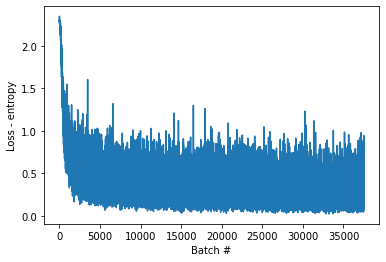

In [11]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss - entropy')
plt.show()


# ***New example for linear, deeper ascess to tf.Variable***

In [2]:
import tensorflow as tf

class Linear(tf.keras.Model):
      def __init__(self):
          super(Linear, self).__init__()
          self.W = tf.Variable(5., name = 'weight', trainable= True)
          self.B = tf.Variable(1., name = 'bias', trainable = True)
      def __call__(self, inputs):
          return inputs*self.W + self.B



In [3]:
Num_egs = 2000
train_inputs = tf.random.normal([Num_egs])
noise = tf.random.normal([Num_egs])
train_outputs = train_inputs*3 + 2 + noise

In [7]:
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.trainable_variables), loss_value


In [36]:
import os
model = Linear()
optimizer = tf.keras.optimizers.SGD(learning_rate= 0.01)

print('Initial loss = ',loss(model, train_inputs, train_outputs))

steps = 400
loss_history = []

checkpoint_dir = './'
root = tf.train.Checkpoint(optimizer = optimizer, model = model)

checkpoint_prefix  = os.path.join(checkpoint_dir, 'ckpt')
root.save(checkpoint_prefix)

for i in range(steps):
    grads, loss_value = grad(model, train_inputs, train_outputs)
    loss_history.append(loss_value)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if i%40 == 0:
        print(f'At step {i//40}, loss = {loss_value}')
        checkpoint_prefix  = os.path.join(checkpoint_dir, 'ckpt'+str(i//40))

    root.save(checkpoint_prefix)

    

Initial loss =  tf.Tensor(6.198461, shape=(), dtype=float32)
At step 0, loss = 6.198461055755615
At step 1, loss = 1.9916844367980957
At step 2, loss = 1.1723103523254395
At step 3, loss = 1.0127116441726685
At step 4, loss = 0.9816240072250366
At step 5, loss = 0.9755683541297913
At step 6, loss = 0.9743886590003967
At step 7, loss = 0.9741589426994324
At step 8, loss = 0.9741140604019165
At step 9, loss = 0.9741054773330688
